In [1]:
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import plotting_extent
from osgeo import gdal 
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import pycrs
import json

file_dir=('/Users/maddie/Projects/CPSC_597/data')

In [2]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/modified_data/gbif_filtered/taxa_list.txt",header=None)
taxa.columns=["taxon"]

species_occ_dict={}

for i in taxa["taxon"]:
    taxon_data = pd.read_csv(file_dir+"/modified_data/gbif_filtered/%s_filtered_data.csv"%i, low_memory=False)
    #add species dataframe to dict
    species_occ_dict["%s"%i] = taxon_data  
    #check whether all species have been included and inspect dictionary
if len(species_occ_dict.keys())==len(taxa["taxon"]):
    print("All species dataframes now in dictionary")
else:
    print("Error: not all species dataframe included")

All species dataframes now in dictionary


In [3]:
for key in species_occ_dict:    
    #load occurrence data and set initial projection
    data=species_occ_dict[key]
    spec = key

    data['coordinates'] = list(zip(data["decimalLongitude"], data["decimalLatitude"]))
    data['coordinates'] = data["coordinates"].apply(Point)
    data["present/pseudo_absent"]=1
    geo_data=gpd.GeoDataFrame(data, geometry='coordinates',crs='epsg:4326')

    #change projection to azimuthal equidistant to calculate 1000km buffer around point
    geo_data = geo_data.to_crs('esri:54032') 
    buffer=geo_data.buffer(5*5)
    buffer=buffer.to_crs(epsg=4326)

    #create single large polygon from individual buffers
    union_buffer=buffer.unary_union

    #first clip the raster based on this extend 
    raster=rasterio.open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')
    
    #specify output tif:
    out_tif = (file_dir+'/modified_data/species_rasters/%s_raster_clip.tif'%spec)

    #clip the raster:
    out_img, out_transform = mask(dataset=raster, shapes=[union_buffer],crop=True)
   
    # Copy the metadata
    out_meta = raster.meta.copy()

    # Parse EPSG code
    epsg_code = int(raster.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_img)

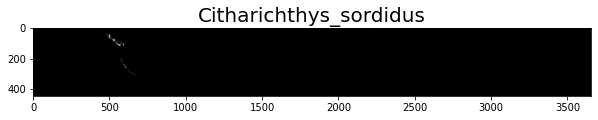

/Users/maddie/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


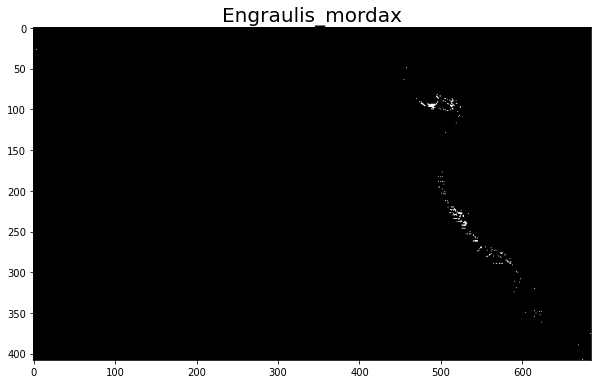

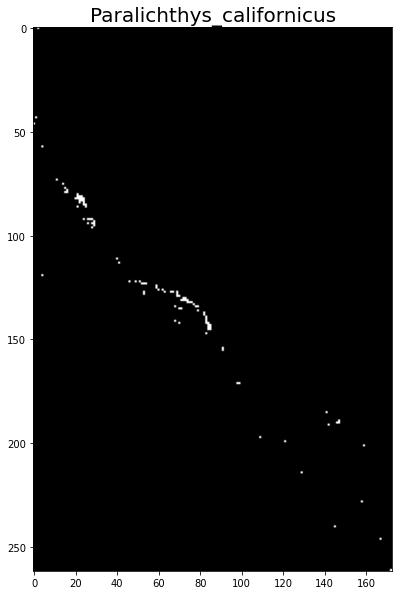

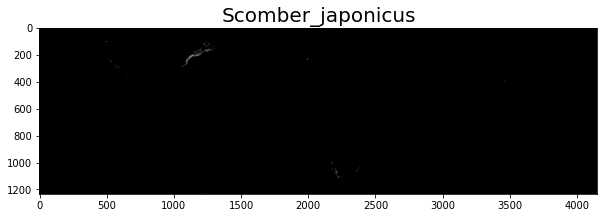

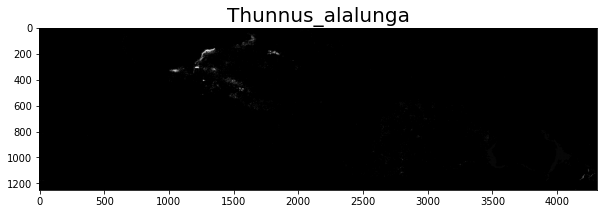

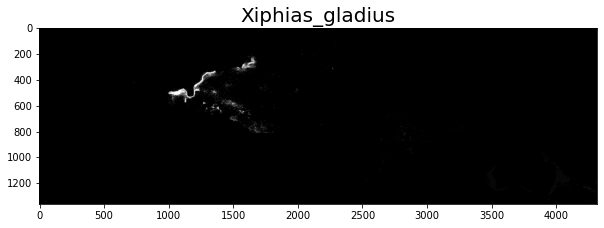

In [4]:
for key in species_occ_dict:  
        
    presence_data = species_occ_dict[key]
    presence_data.rename(columns = {'decimalLongitude':'decimal_longitude', 'decimalLatitude':'decimal_latitude',}, inplace = True)
    presence_data["present/pseudo_absent"]=1
    spec = key

    
    long=presence_data["decimal_longitude"]
    lati=presence_data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)
   
    #read raster
    src=rasterio.open(file_dir+'/modified_data/species_rasters/%s_raster_clip.tif'%spec)
    array=src.read_masks(1)
    
    # set raster cell mask values of presence locations to threshold value (=1) to exclude them from pseudo-absence sampling
    for i in range(0,len(presence_data)):
        row,col=src.index(long[i],lati[i])
        array[row,col]=1

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array,cmap="gray")
    ax.set_title("%s"%spec,
             fontsize=20)
    plt.show()


    (y_index, x_index) = np.nonzero(array)


    #sample random locations from raster excludin presence cells
    r = gdal.Open(file_dir+'/modified_data/species_rasters/%s_raster_clip.tif'%spec)
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
    

    x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point

    #print(x_coords)
    #print(y_coords)

    lon_lat_array=np.stack((x_coords,y_coords)).T
    random_sample_size= np.random.randint(500,1000)

    random_sample_lon_lats=lon_lat_array[np.random.choice(lon_lat_array.shape[0], random_sample_size), :] ##
    

    #Add selected cells to dataset
    lon=[]
    lat=[]
    psa=[0]*random_sample_size
    taxon=["%s"%spec]*random_sample_size
    gbif=["no_id"]*random_sample_size

    for item in random_sample_lon_lats:
        longitude=item[0]
        latitude=item[1]
        lon.append(longitude)
        lat.append(latitude)
    
  

    #Dataset including occurrences and pseudo-absence points
    new_data=pd.DataFrame({"gbif_id": gbif,"taxon_name":taxon,"decimal_longitude": lon, "decimal_latitude":lat, "present/pseudo_absent": psa})
    data=pd.concat([presence_data,new_data],ignore_index=True)
    data=data[['taxon_name','gbif_id','decimal_longitude','decimal_latitude','present/pseudo_absent']]
    data["taxon_name"]=spec
    data["row_n"]=np.arange(len(data))
     
    long=data["decimal_longitude"]
    lati=data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)
    
    
    
    #read raster
    src=rasterio.open(file_dir+'/modified_data/species_rasters/%s_raster_clip.tif'%spec)
    array = src.read_masks(1)


    
    data=data.reset_index(drop=True)
    data.to_csv(file_dir + "/modified_data/spec_ppa/%s_ppa_dataframe.csv"%spec)

#next species
    

In [5]:
raster=rasterio.open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')
array = raster.read()
profile=raster.profile

with open(file_dir+'/modified_data/stacked_bio_oracle/env_bio_mean_std.txt','w+') as file:
    file.write("band"+"\t"+"mean"+"\t"+"std_dev"+"\n")
    file.close()

#no data value might vary across band, try to find lowest no data value across raster bands
min_abs=0

for band in array:
    minb=np.min(band)
    if minb < min_abs:
        min_abs=minb

#create same minimum in each band
for i in range(1,9):
    print(i)
    profile.update(count=1)
    band=raster.read(i)
    band[band == -9999] = min_abs
    
    #mask the cell values based on no data value
    band_masked = np.ma.masked_array(band, mask=(band == min_abs)) 
    
    #calculate mean and std.dev of each band
    mean=band_masked.mean()
    std_dev=np.std(band_masked)
    
    #write to file
    with open(file_dir+'/modified_data/stacked_bio_oracle/env_bio_mean_std.txt','a') as file:
        file.write(str(i)+"\t"+str(mean)+"\t"+str(std_dev)+"\n")


1
2
3
4
5
6
7
8


In [6]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/modified_data/gbif_filtered/taxa_list.txt",header=None)
taxa.columns=["taxon"]

In [7]:
for i in taxa["taxon"]:
    
    data = pd.read_csv(file_dir+'/modified_data/spec_ppa/%s_ppa_dataframe.csv'%i)
    spec = data["taxon_name"][0]
    spec = spec.replace(" ","_") 
    print("processing species ", spec)
    

    #get all collumn and row numbers
    len_pd=np.arange(len(data))
    long=data["decimal_longitude"]
    lati=data["decimal_latitude"]
    ppa=data["present/pseudo_absent"]



    lon=long.values
    lat=lati.values

    row=[]
    col=[]

    src=rasterio.open(file_dir+'/modified_data/species_rasters/%s_raster_clip.tif'%spec)

    for i in len_pd:
        row_n, col_n = src.index(lon[i], lat[i])# spatial --> image coordinates
        row.append(row_n)
        col.append(col_n)

    ##opening raster as 3d numpy array
    inRas=gdal.Open(file_dir+'/modified_data/species_rasters/%s_raster_clip.tif'%spec)
    myarray=inRas.ReadAsArray()
    

    #collect file with mean and std_dev for each band
    mean_std=pd.read_csv(file_dir+'/modified_data/stacked_bio_oracle/env_bio_mean_std.txt',sep="\t")
    mean_std=mean_std.to_numpy()


    ##########################################################
    #extract the values for all bands and prepare input data #
    ##########################################################
    X=[]
    species =["%s"%spec]*int(len(row))

    for j in range(0,8):
        band=myarray[j]
        x=[]

        for i in range(0,len(row)):
            value= band[row[i],col[i]]
            if value <-1.7e+307:
                value=np.nan
                x.append(value)
            else:
                value = ((value - mean_std.item((j,1))) / mean_std.item((j,2)))#scale values
                x.append(value)
        X.append(x)


    #set as numpy 2d array
    X =np.array([np.array(xi) for xi in X])

    #transform into dataframe and include row and column values
    df=pd.DataFrame(X)
    df=df.T

    df["present/pseudo_absent"]=ppa
    df["decimal_latitude"]=lati
    df["decimal_longitude"]=long
    df["taxon_name"]=species
    df["present/pseudo_absent"]=ppa
    df["row_n"]=row
    
    #drop any potential rows with no-data values
    df=df.dropna(axis=0, how='any')
    input_data=df
    
    ##save input dataframe
    input_data.to_csv(file_dir +"/modified_data/spec_ppa_env/%s_env_dataframe.csv"%spec)

processing species  Citharichthys_sordidus
processing species  Engraulis_mordax
processing species  Paralichthys_californicus
processing species  Scomber_japonicus
processing species  Thunnus_alalunga
processing species  Xiphias_gladius


In [8]:
##opening raster as 3d numpy array
inRas=gdal.Open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')
myarray=inRas.ReadAsArray()


#get all collumn and row values for all cells to predict over
df=pd.read_csv(file_dir+'/world_locations_to_predict.csv')

len_pd=np.arange(len(df))
lon=df["decimal_longitude"]
lat=df["decimal_latitude"]
lon=lon.values
lat=lat.values

row=[]
col=[]

src=rasterio.open(file_dir+'/modified_data/stacked_bio_oracle/bio_oracle_stacked.tif')

for i in len_pd:
    row_n, col_n = src.index(lon[i], lat[i])# spatial --> image coordinates
    row.append(row_n)
    col.append(col_n)

#collect file with mean and std_dev for each band
mean_std=pd.read_csv(file_dir+'/modified_data/stacked_bio_oracle/env_bio_mean_std.txt',sep="\t")
mean_std=mean_std.to_numpy()


###########################################################
# extract the values for all bands and prepare input data #
###########################################################
X=[]

for j in range(0,8):
    print(j)
    band=myarray[j]
    x=[]

    for i in range(0,len(row)):
        value= band[row[i],col[i]]
        if value <-1.7e+305:
            value=np.nan
            x.append(value)
        else:
            value = ((value - mean_std.item((j,1))) / mean_std.item((j,2))) # scale values
            x.append(value)
    X.append(x)

#include row and column values
X.append(row)
X.append(col)

#set as numpy 2d array
X =np.array([np.array(xi) for xi in X])

df=pd.DataFrame(X)
df=df.T

#drop any rows with no-data values
df=df.dropna(axis=0, how='any')
input_X=df.loc[:,0:7]

row=df[8]
col=df[9]

row_col=pd.DataFrame({"row":row,"col":col})

#convert dataframe back to numpy array
input_X=input_X.values
#convert rows and col indices back to array
row=row.values
col=col.values

#save
prediction_array=np.save(file_dir+'/world_prediction_array.npy',input_X)
prediction_pandas=row_col.to_csv(file_dir+'/world_prediction_row_col.csv')

0
1
2
3
4
5
6
7
